In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
data = pd.read_csv('titanic.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#checking for null values
nullValues = data.isnull().sum()
nullValues

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
#deleting all the columns whose missing values are over 20%
delCols = ['PassengerId', 'Name', 'Ticket']
for i, v in nullValues.items():
    if (v/data.shape[0]) > 0.2:
        delCols.append(i)
data.drop(delCols, axis = 1, inplace = True)

In [6]:
#replacing male and female to 0 and 1
data['Sex'].replace({'male' : 0, 'female' : 1}, inplace = True)

In [7]:
#one hot encoding passenger class
data = pd.get_dummies(data, columns = ['Pclass'])

In [8]:
#seperating labels and attributes
X = data.drop('Survived', axis = 1)
y = data['Survived']

In [9]:
#seperating the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
#creating a function to fill in the missing values with the most common values
def fillMissing(df, ref): 
    #df is the dataframe in which we'll fill in the values
    #ref is the reference dataframe
    missingItems = df.isnull().sum()
    missingCols = []
    r = ref.mode()
    for i, v in missingItems.items():
        if v != 0:
            missingCols.append(i)
    for col in missingCols:
        df[col] = df[col].fillna(r[col][0])

In [11]:
#filling in the missing values in X_train and X_val using X_train properties
fillMissing(X_train, X_train)
fillMissing(X_val, X_train)

In [12]:
#one hot encoding
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)

In [13]:
#changing labels to 1 and -1 for simplification
y_train = np.where(y_train < 1, -1, y_train)
y_val = np.where(y_val < 1, -1, y_val)

# Modelling

In [14]:
#Implementing AdaBoost using OOPS
class AdaBoost():
    def __init__(self):
        self.forest = None #stores the forest
        self.smoothingFactor = 10 ** -10
        self.w = None #sample weights
        self.pred = None #predictions
        self.acc = None #accuracy on a test/train set
        self.n_estimators = None #number of estimators/trees
        self.bestAcc = None #stores the best accuracy
        self.bestNEstimators = None #best number of estimators to use
    
    def fit(self, X_train, y_train, n_estimators = 100, random_state = 42):
        #fit method to train the model
        self.n_estimators = n_estimators
        self.forest = []
        for i in range(n_estimators):
            if i == 0:
                self.w = np.full(len(y_train), 1 / len(y_train)) #initialize sample weights
            dt = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes = 2, random_state = random_state) #create a stub(small tree with only one node)
            dt.fit(X_train, y_train, sample_weight = self.w) #train the stub
            pred = dt.predict(X_train) #get stub prediction
            
            wrongPred = y_train != pred #get all the wrong predictions
            correctPred = y_train == pred #get all the correct predictions
            totalError = self.w[wrongPred].sum() + self.smoothingFactor #calculate the total error
            alpha = 0.5 * np.log((1 - totalError) / totalError) #calculate alpha
            self.forest.append((dt, alpha)) #add the stub and it's corresponding alpha value in the forest array
            
            #update weights
            newWeights = self.w[wrongPred] * np.exp(alpha) #increase the weight of incorrect predictions
            self.w[wrongPred] = newWeights #update weights
            newWeights = self.w[correctPred] * np.exp(-alpha) #decrease the weight of correct predictions
            self.w[correctPred] = newWeights #update weights
            
            #normalize the new weights
            currWeight = self.w.sum()
            self.w = self.w / currWeight
        
    def evaluate(self, X, y):
        #method to evaluate the model on the test data
        self.__getAcc__(X, y) #get accuracy till each stub
        self.bestAcc = max(self.acc) #store the best accuracy
        self.bestNEstimators = self.acc.index(self.bestAcc) + 1 #store the best estimator limit
        #plot accuracy over estimators
        plt.plot(range(self.n_estimators), self.acc)
        plt.xlabel("Number of estimators")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs n_estimators")
        print("Best Accuracy :", self.bestAcc)
        print("Best Number of Estimators :", self.bestNEstimators)
            
    def __getAcc__(self, X, y):
        #helper method to get accuracy till each stub
        self.acc = []
        for i in range(self.n_estimators):
            p = self.__predict__(X, i + 1)
            acc = accuracy_score(y, p)
            self.acc.append(acc)
    
    def predict(self, X_val):
        #prediction method
        self.pred = self.__predict__(X_val, self.n_estimators)
        return self.pred
    
    def __predict__(self, X, size):
        #helper method to predict till each stub
        pred = []
        for dt, alpha in self.forest[:size]:
            p = dt.predict(X)
            p = p * alpha
            pred.append(p)
        pred = np.array(pred)
        pred = np.sum(pred, axis = 0)
        pred = np.where(pred > 0, 1, -1)
        return pred

# Training the model

In [15]:
ada = AdaBoost()
ada.fit(X_train, y_train, 500)

In [16]:
print("Classification Report for Training Set")
print()
pred = ada.predict(X_train)
print(classification_report(y_train, pred))

Classification Report for Training Set

              precision    recall  f1-score   support

          -1       0.86      0.88      0.87       444
           1       0.80      0.75      0.77       268

    accuracy                           0.83       712
   macro avg       0.83      0.82      0.82       712
weighted avg       0.83      0.83      0.83       712



# Evaluating the model

In [17]:
print("Classification Report for Testing Set")
print()
pred = ada.predict(X_val)
print(classification_report(y_val, pred))

Classification Report for Testing Set

              precision    recall  f1-score   support

          -1       0.83      0.84      0.83       105
           1       0.77      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



# Finding the best accuracy and estimators for training and testing set

Graph and best parameters for Training Set

Best Accuracy : 0.8370786516853933
Best Number of Estimators : 445


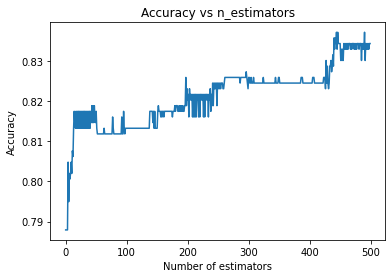

In [18]:
print("Graph and best parameters for Training Set")
print()
ada.evaluate(X_train, y_train)

Graph and best parameters for Testing Set

Best Accuracy : 0.8156424581005587
Best Number of Estimators : 199


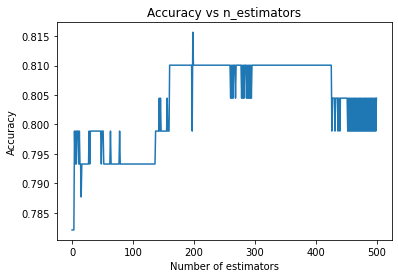

In [19]:
print("Graph and best parameters for Testing Set")
print()
ada.evaluate(X_val, y_val)